In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import matplotlib.pyplot as plt

# Load datasets for Plant 1
plant1_gen = pd.read_csv('Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

In [ ]:
# Merge datasets on common keys (assuming 'DATE_TIME' is the common key)
plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME'])
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_weather['DATE_TIME'])
plant1 = pd.merge(plant1_gen, plant1_weather, on='DATE_TIME', suffixes=('_gen', '_weather'))

# Feature engineering
plant1['hour'] = plant1['DATE_TIME'].dt.hour
plant1['day'] = plant1['DATE_TIME'].dt.day
plant1['month'] = plant1['DATE_TIME'].dt.month
plant1['year'] = plant1['DATE_TIME'].dt.year

# Define features and target
features = ['hour', 'day', 'month', 'year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'AC_POWER'

# Drop rows with missing target values for training
train_data = plant1.dropna(subset=[target])

# Fill missing feature values
train_data = train_data.fillna(method='ffill')

<ipython-input-17-91e9ebca5c42>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME'])


In [ ]:
# Merge datasets on common keys (assuming 'DATE_TIME' is the common key)
plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME'])
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_weather['DATE_TIME'])
plant1 = pd.merge(plant1_gen, plant1_weather, on='DATE_TIME', suffixes=('_gen', '_weather'))

# Feature engineering
plant1['hour'] = plant1['DATE_TIME'].dt.hour
plant1['day'] = plant1['DATE_TIME'].dt.day
plant1['month'] = plant1['DATE_TIME'].dt.month
plant1['year'] = plant1['DATE_TIME'].dt.year

# Define features and target
features = ['hour', 'day', 'month', 'year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'AC_POWER'

# Drop rows with missing target values for training
train_data = plant1.dropna(subset=[target])

# Fill missing feature values
train_data = train_data.fillna(method='ffill')

In [ ]:
# Define hyperparameter grids for tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Function for hyperparameter tuning using RandomizedSearchCV
def tune_model(model, param_grid, X_train, y_train):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42, verbose=2)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

# Tune models
rf_best_model = tune_model(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
# Evaluate tuned models on training and testing sets
def evaluate_model_on_train_test(model_name, model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    print(f"{model_name} - Training MAE: {train_mae:.2f}, Testing MAE: {test_mae:.2f}")
    print(f"{model_name} - Training RMSE: {train_rmse:.2f}, Testing RMSE: {test_rmse:.2f}")
    print(f"{model_name} - Training R2: {train_r2:.2f}, Testing R2: {test_r2:.2f}")

# Evaluate the best models
evaluate_model_on_train_test("Tuned Random Forest", rf_best_model, X_train, y_train, X_test, y_test)

Tuned Random Forest - Training MAE: 15.53, Testing MAE: 16.37
Tuned Random Forest - Training RMSE: 45.21, Testing RMSE: 45.59
Tuned Random Forest - Training R2: 0.99, Testing R2: 0.99


In [ ]:
# Define the base models for stacking
base_models = [
    ('rf', rf_best_model),
]

# Define the meta-model
meta_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)

# Create the stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Evaluate the stacking ensemble
stacking_preds = stacking_model.predict(X_test)
mae_stacking = mean_absolute_error(y_test, stacking_preds)
rmse_stacking = np.sqrt(mean_squared_error(y_test, stacking_preds))
r2_stacking = r2_score(y_test, stacking_preds)
print(f"Stacking Ensemble - MAE: {mae_stacking:.2f}, RMSE: {rmse_stacking:.2f}, R2: {r2_stacking:.2f}")

Stacking Ensemble - MAE: 17.36, RMSE: 47.86, R2: 0.99


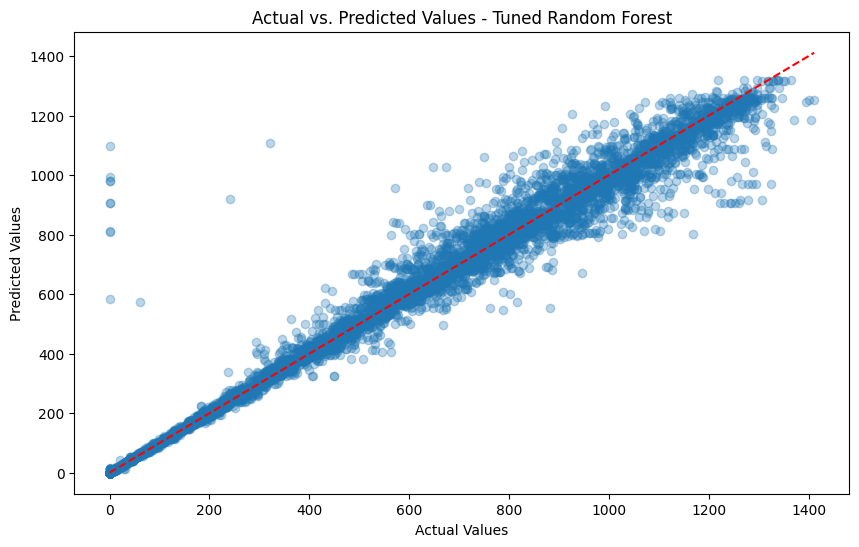

In [ ]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(model_name, model, X_test, y_test):
    preds = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.show()

# Plot for each tuned model
plot_actual_vs_predicted("Tuned Random Forest", rf_best_model, X_test, y_test)

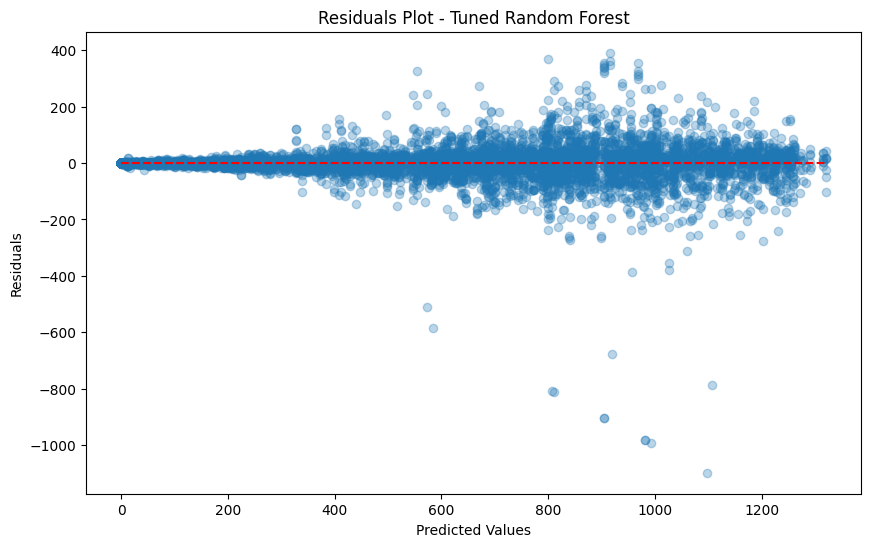

In [ ]:
# Function to plot residuals
def plot_residuals(model_name, model, X_test, y_test):
    preds = model.predict(X_test)
    residuals = y_test - preds
    plt.figure(figsize=(10, 6))
    plt.scatter(preds, residuals, alpha=0.3)
    plt.hlines(y=0, xmin=preds.min(), xmax=preds.max(), colors='r', linestyles='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {model_name}')
    plt.show()

# Residual plots for each tuned model
plot_residuals("Tuned Random Forest", rf_best_model, X_test, y_test)